### Imports

In [ ]:
%pip install xgboost

In [35]:
# Import necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
import xgboost as xgb

### Dataset

In [1]:
# Download the dataset
!wget https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv

--2024-11-03 13:59:26--  https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alexeygrigorev/datasets/refs/heads/master/jamb_exam_results.csv [following]
--2024-11-03 13:59:30--  https://raw.githubusercontent.com/alexeygrigorev/datasets/refs/heads/master/jamb_exam_results.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 391501 (382K) [text/plain]
Saving to: 'jamb_exam_results.csv'

     0K .......... .......... .......... .......... .......... 13% 1.19M 0s
    50K .......... .......... .......... .......... ....

### Preparing the dataset

In [3]:
# Load the dataset
df = pd.read_csv('jamb_exam_results.csv', sep=',')
df

,JAMB_Score,Study_Hours_Per_Week,Attendance_Rate,Teacher_Quality,Distance_To_School,School_Type,School_Location,Extra_Tutorials,Access_To_Learning_Materials,Parent_Involvement,IT_Knowledge,Student_ID,Age,Gender,Socioeconomic_Status,Parent_Education_Level,Assignments_Completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,2,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,3,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,4,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,5,22,Female,Medium,Tertiary,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,183,20,74,2,10.6,Public,Urban,Yes,No,Low,Low,4996,16,Male,Medium,Primary,2
4996,179,0,80,2,20.0,Public,Rural,No,Yes,Medium,Medium,4997,22,Male,Low,Secondary,1
4997,261,17,89,3,11.3,Public,Urban,No,No,Low,High,4998,18,Male,Medium,Primary,3
4998,183,15,96,2,15.9,Public,Rural,No,No,Low,Medium,4999,18,Male,Medium,Secondary,1


In [5]:
# Convert the column names to lowercase and replace spaces with underscores
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head()

,jamb_score,study_hours_per_week,attendance_rate,teacher_quality,distance_to_school,school_type,school_location,extra_tutorials,access_to_learning_materials,parent_involvement,it_knowledge,student_id,age,gender,socioeconomic_status,parent_education_level,assignments_completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,2,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,3,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,4,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,5,22,Female,Medium,Tertiary,1


In [7]:
# Remove the 'student_id' column
df = df.drop(columns=['student_id'])

In [8]:
# Fill missing values with zeros
df = df.fillna(0)

In [10]:
# Train/validation/test split with a 60%/20%/20% distribution
df_train, df_temp = train_test_split(df, test_size=0.4, random_state=1)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=1)

In [12]:
# Define the target variable
y_train = df_train['jamb_score'].values
y_val = df_val['jamb_score'].values
y_test = df_test['jamb_score'].values

# Drop 'jamb_score' from the feature sets to avoid data leakage
df_train = df_train.drop(columns=['jamb_score'])
df_val = df_val.drop(columns=['jamb_score'])
df_test = df_test.drop(columns=['jamb_score'])

In [13]:
# Convert the dataframes to dictionaries
train_dict = df_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')
test_dict = df_test.to_dict(orient='records')

In [14]:
# Initialize DictVectorizer
dv = DictVectorizer(sparse=True)

# Transform each dataset
X_train = dv.fit_transform(train_dict)  
X_val = dv.transform(val_dict)          
X_test = dv.transform(test_dict)        

In [15]:
# Print the shapes
print (X_train.shape)
print (X_val.shape)
print (X_test.shape)

(3000, 29)
(1000, 29)
(1000, 29)


## Question 1

In [16]:
# Initialize the Decision Tree Regressor with max_depth=1
dt = DecisionTreeRegressor(max_depth=1, random_state=1)

# Train the model on the training data
dt.fit(X_train, y_train)

# Check which feature is used for splitting
feature_importance = dt.feature_importances_

# Get the index of the feature used for splitting
split_feature_index = feature_importance.argmax()
split_feature_name = dv.feature_names_[split_feature_index]

print(f"The feature used for splitting the data is: {split_feature_name}")

The feature used for splitting the data is: study_hours_per_week


## Question 2

In [22]:
# Initialize the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)

# Train the model on the training data
rf.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_val_rf = rf.predict(X_val)

# Calculate RMSE on the validation set using the updated method
val_rmse_rf = root_mean_squared_error(y_val, y_pred_val_rf)
print(f"Validation RMSE: {val_rmse_rf}")

Validation RMSE: 43.157758977963624


## Question 3

In [26]:
# List to store RMSE results
rmse_values = []
n_estimators_range = range(10, 201, 10)

# Loop over values of n_estimators
for n in n_estimators_range:
    # Initialize and train the model
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    # Predict on the validation set
    y_pred_val_rf = rf.predict(X_val)
    
    # Calculate RMSE and store it
    rmse = root_mean_squared_error(y_val, y_pred_val_rf)
    rmse_values.append((n, rmse))

# Create a DataFrame to view RMSE values at each n_estimators step
rmse_df = pd.DataFrame(rmse_values, columns=['n_estimators', 'RMSE'])
rmse_df

,n_estimators,RMSE
0,10,43.157759
1,20,41.790440
2,30,41.555818
3,40,41.075632
4,50,40.957157
5,60,40.773685
6,70,40.587806
7,80,40.502704
8,90,40.434922
9,100,40.364910


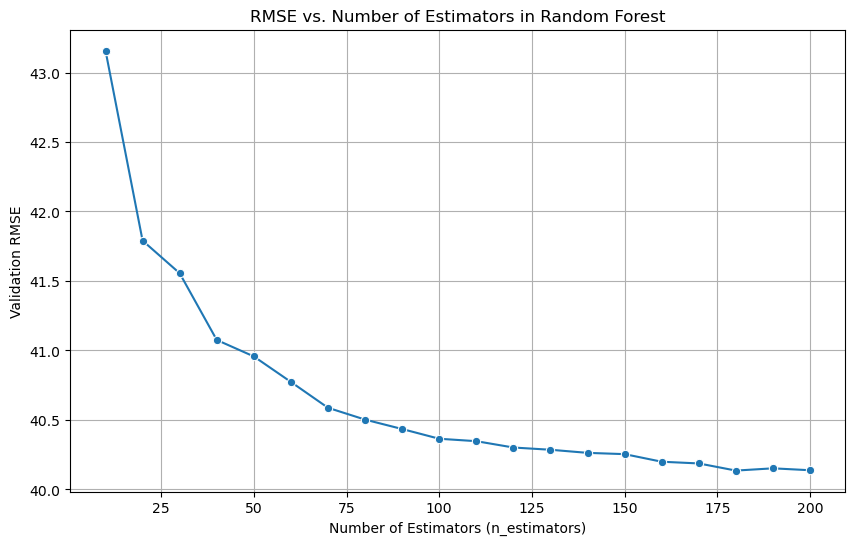

In [29]:
# Plot the RMSE values using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=rmse_df, x='n_estimators', y='RMSE', marker='o')
plt.xlabel("Number of Estimators (n_estimators)")
plt.ylabel("Validation RMSE")
plt.title("RMSE vs. Number of Estimators in Random Forest")
plt.grid(True)
plt.show()

## Question 4

In [30]:
# Testing different values of max_depth and n_estimators to find the best combination
results = []

# Define the range for max_depth and n_estimators
max_depth_values = [10, 15, 20, 25]
n_estimators_range = range(10, 201, 10)

# Loop over each max_depth value
for max_depth in max_depth_values:
    rmse_list = []

    # Loop over n_estimators values
    for n in n_estimators_range:
        # Initialize and train the RandomForestRegressor
        rf = RandomForestRegressor(n_estimators=n, max_depth=max_depth, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)

        # Predict on the validation set
        y_pred_val_rf = rf.predict(X_val)

        # Calculate RMSE and store it
        rmse = root_mean_squared_error(y_val, y_pred_val_rf)
        rmse_list.append(rmse)

    # Calculate mean RMSE for the current max_depth
    mean_rmse = np.mean(rmse_list)
    results.append((max_depth, mean_rmse))

# Convert the results to a DataFrame to display the best max_depth based on mean RMSE
results_df = pd.DataFrame(results, columns=['max_depth', 'mean_RMSE'])
best_max_depth = results_df.loc[results_df['mean_RMSE'].idxmin()]['max_depth']
best_max_depth

10.0

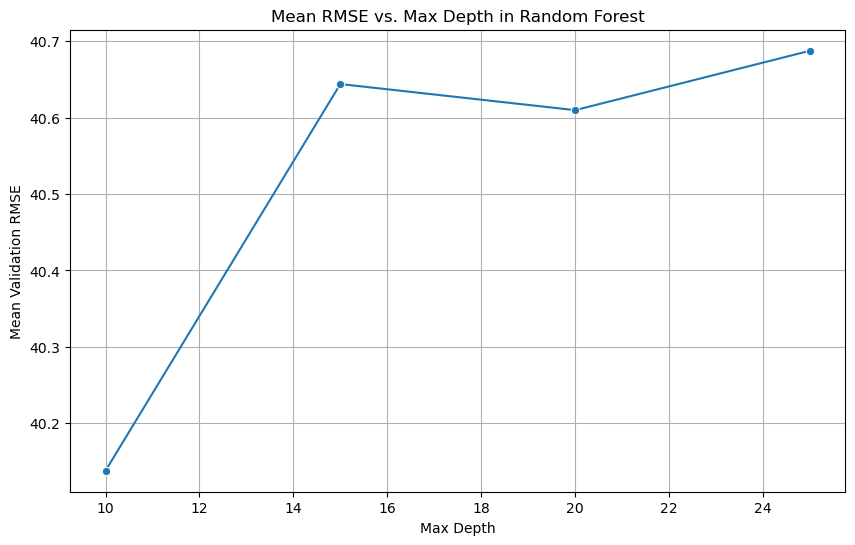

In [31]:
# Plot mean RMSE by max_depth using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='max_depth', y='mean_RMSE', marker='o')
plt.xlabel("Max Depth")
plt.ylabel("Mean Validation RMSE")
plt.title("Mean RMSE vs. Max Depth in Random Forest")
plt.grid(True)
plt.show()

## Question 5

In [32]:
# Initialize the RandomForestRegressor with specified parameters
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)

# Train the model
rf.fit(X_train, y_train)

# Extract feature importance information
feature_importances = rf.feature_importances_

# Pair the feature names with their importances
feature_importance_df = pd.DataFrame({
    'Feature': dv.feature_names_, 
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the most important feature
print("Most important feature:")
print(feature_importance_df.head(1))

Most important feature:
                 Feature  Importance
27  study_hours_per_week    0.254075


## Question 6

In [34]:
# Convert data to DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Define a watchlist to monitor training and validation metrics
watchlist = [(dtrain, 'train'), (dval, 'val')]

# Initial parameters with eta=0.3
xgb_params_1 = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

In [39]:
# Train model with eta=0.3
model_1 = xgb.train(xgb_params_1, dtrain, num_boost_round=100, evals=watchlist, early_stopping_rounds=10)
y_pred_val_1 = model_1.predict(dval)
rmse_1 = root_mean_squared_error(y_val, y_pred_val_1)

# Change eta to 0.1
xgb_params_2 = xgb_params_1.copy()
xgb_params_2['eta'] = 0.1

# Train model with eta=0.1
model_2 = xgb.train(xgb_params_2, dtrain, num_boost_round=100, evals=watchlist, early_stopping_rounds=10)
y_pred_val_2 = model_2.predict(dval)
rmse_2 = np.sqrt(root_mean_squared_error(y_val, y_pred_val_2))

[0]	train-rmse:42.84835	val-rmse:44.52338
[1]	train-rmse:39.96423	val-rmse:42.83406
[2]	train-rmse:37.91231	val-rmse:41.62607
[3]	train-rmse:36.51126	val-rmse:41.25491
[4]	train-rmse:35.52212	val-rmse:40.84075
[5]	train-rmse:34.77126	val-rmse:40.71677
[6]	train-rmse:34.03898	val-rmse:40.72669
[7]	train-rmse:33.62820	val-rmse:40.68822
[8]	train-rmse:32.94729	val-rmse:40.81273
[9]	train-rmse:32.27703	val-rmse:40.84939
[10]	train-rmse:31.73818	val-rmse:40.83759
[11]	train-rmse:31.31360	val-rmse:40.80575
[12]	train-rmse:30.72949	val-rmse:40.84238
[13]	train-rmse:30.11486	val-rmse:40.96020
[14]	train-rmse:29.43538	val-rmse:40.98775
[15]	train-rmse:29.23018	val-rmse:41.04798
[16]	train-rmse:28.64113	val-rmse:41.08375
[17]	train-rmse:28.42128	val-rmse:41.15979
[0]	train-rmse:45.64414	val-rmse:46.63724
[1]	train-rmse:44.26862	val-rmse:45.58724
[2]	train-rmse:43.08569	val-rmse:44.76209
[3]	train-rmse:42.05227	val-rmse:44.02498
[4]	train-rmse:41.10533	val-rmse:43.40640
[5]	train-rmse:40.28309	va

In [40]:
# Compare RMSE for both eta values
print(f"Validation RMSE with eta=0.3: {rmse_1}")
print(f"Validation RMSE with eta=0.1: {rmse_2}")

# Determine which eta leads to the best RMSE
if rmse_1 < rmse_2:
    print("Best eta: 0.3")
elif rmse_2 < rmse_1:
    print("Best eta: 0.1")
else:
    print("Both eta values give equal RMSE")

Validation RMSE with eta=0.3: 41.15979263175636
Validation RMSE with eta=0.1: 6.344868565278555
Best eta: 0.1
